### 2022 开源之夏MindSpore任务结项报告

#### 1.项目基本信息
+ 项目名称：基于昇思MindQuantum，实现量子虚时演化算法
+ 项目编号：221cb0176
+ 项目主导师：谢晴兴 <634436649@qq.com>
+ 项目承接人：储贻达 <chu_yi_da@163.com>
+ 项目难度：进阶
+ 项目要求：1. 实现变分线路参数的量子虚时演化算法，用于求解分子体系的基态能 2. 探索其它形式的量子虚时演化算法 3. 实现相关功能，相关评估指标符合要求，代码合入社区
+ 项目技术要求：深度学习，python，量子计算，MindSpore

---

#### 2.项目基本原理描述

#### (1). 摘要

Imaginary time evolution is a powerful tool for studying quantum systems. While it is possible to simulate with a classical computer,the time and memory requirements generally scale exponentially with the system size. Conversely, quantum computers can
efficiently simulate quantum systems, but not non-unitary imaginary time evolution. So in this year's Open Source Promotion Plan, we think about wheter this imaginary time evolution algorithm can be accomplished by quantum computer. In fact, there have been some studies in this area that have given some solutions. For example, in this artical [Motta, Mario, et al.Nature Physics 16.2 (2020): 205-210], an algorithm is proposed to make this non-unitary evolution possible in quantum circuits, which is called the QITE(Qauntum Imaginary Time Evolution) algorithm. In addition to this, other methods are also proposed in another article [McArdle, Sam, et al.npj Quantum Information 5.1 (2019): 1-6.]. Different from the former approach, McArdle, Sam, et al. pointed out that a variational algorithm enables quantum circuits to simulate the process of imagnary time evolution, which is called the VITE(Variational quantum Imaginary Time Evolution) algorithm. And the effect of the algorithm on solving the ground state energy of the molecular system is shown in the article. In addition, we also found that the VITE algorithm is very suitable to be implemented with the Mindspore quantum[] library. Therefore, in this Open Source Promotion Plan project, we refer to the principle of this article, and think about how to use the MindSpore quantum library to complete this VITE algorithm and verify its effectiveness. And on this basis, the algorithm program is used to solve the ground state energy of some more complex molecular systems. Finally, we also explore the performance of this algorithm in the presence of quantum noise.

#### (2). 理论概述

In a quantum many-body systems that are described by Hamiltonian $H$, if given an initial state $| \psi \rangle$, the normalised imaginary time evolution is defined by 
$$| \psi (\tau) \rangle  = A(\tau) e^{-H \tau} | \psi (0) \rangle$$
where the $A(\tau) = 1/ \sqrt{\langle \psi(0)| e^{-2H\tau}| \psi(0) \rangle}$ is a normalisation factor. And when the initial state has a non-zero overlap with the ground state, the state at $\tau \to \infty$ is the ground state of $H$. It is precisely because this principle that we can choose the appropriate initial state to obtain the ground state of a quantum system by imaginary time evolution.

In variational method, we can approximate the evolution state using a parametrised trial state $| \phi (\vec{\theta}(\tau)) \rangle$, with $\vec{\theta}(\tau) = ( \theta_1(\tau), \theta_2(\tau),\ldots, \theta_N(\tau) )$. And using the quantum circuit, we can prepare the trial state $| \phi (\vec{\theta}) \rangle$ by applying a sequence of parametrised unitary gates,
$$ V(\vec{\theta}) = U_N(\theta_N) \ldots U_k(\theta_k) \ldots U_1(\theta_1) $$
to the initial state $|\bar{0} \rangle$. We express this as $|\phi(\vec{\theta}) \rangle = V(\vec{\theta}) | \bar{0} \rangle$ and remark that $V(\vec{\theta})$ is also referred to as the ansatz.

And in this artical it's pointed that we can use the McLachlan's variational principle to simulate the imaginary time evolution of the trial state:
$$ \delta || \left( \partial/\partial \tau + H - E_{\tau} \right) | \psi(\tau) \rangle || = 0$$
where the $|| \rho || = Tr \left[ \sqrt{\rho \rho^{\dagger}} \right]$ denotes the trace norm of a state and $E_{\tau} = \langle \psi{\tau} | H | \psi{\tau} \rangle$. So we can use this variational principle by replacing the $| \psi (\tau) \rangle$ with $| \phi (\tau) \rangle = | \phi (\vec{\theta}(\tau))$.

So we can get
$$ 
\begin{align}
|| \partial/ \partial \tau + H - E_{\tau} | \psi(\tau) \rangle || 
& = 
\left( (\partial/\partial \tau + H - E_{\tau}) | \psi(\tau) \rangle \right)^{\dagger}
\left( (\partial/\partial \tau + H - E_{\tau}) | \psi(\tau) \rangle \right) \\ 
& = 
\sum_{i,j} \frac{\partial \langle \phi (\tau) |}{\partial \theta_i} \frac{\partial | \phi (\tau) \rangle}{\partial \theta_j} \dot{\theta_i} \dot{\theta_j} + \sum_{i} \frac{\partial \langle \phi(\tau)|}{\partial \theta_i} \left( H - E_{\tau} \right) | \phi(\tau)\rangle \dot{\theta_i} \\
& = 
\sum_{i} \langle \phi(\tau)| (H - E_\tau) \frac{\partial | \phi (\tau)\rangle}{\partial \theta_i} \dot{\theta_i} 
+ \langle \phi(\tau)| \left( H - E_\tau \right)^2 | \phi(\tau)\rangle.
\end{align}
$$
Focusing on $\dot{\theta_i}$, we obtain 
$$ 
\begin{align}
\frac{(\partial || \partial / \partial \tau + H - E_\tau ) | \phi(\tau) \rangle||}{\partial \dot{\theta_i}}
& = \sum_{j} \left( \frac{\partial \langle \phi(\tau)|}{\partial \theta_i} \frac{\partial | \phi (\tau) \rangle}{\partial \theta_j} + \frac{\partial \langle \phi (\tau)|}{\partial \theta_j} \frac{\partial | \phi (\tau) \rangle}{\partial \theta_i} \right) \dot{\theta_j} \\
& + \frac{\partial \langle \phi (\tau)|}{\partial \theta_i} (H - E_\tau)|\phi(\tau) \rangle + \langle \phi (\tau) | (H - E_\tau) \frac{\partial \phi (\tau) \rangle}{\partial \theta_i}
\end{align}
$$
Considering the normalisation condition for the trial state $| \phi (\tau) \rangle$,
$$ \langle \phi(\tau)| \phi(\tau) \rangle = 1,$$
we have 

$$
E_\tau \frac{\partial \langle \phi(\tau)|\phi(\tau)\rangle}{\partial \theta_i}
= E_\tau \left( \frac{\partial \langle \phi (\tau) |}{\partial \theta_i} | \phi(\tau) \rangle 
+ \langle \phi(\tau)| \frac{\partial | \phi (\tau) \rangle}{\partial \theta_i} \right) = 0 
$$
and the derivative is simplified to
$$
\frac{\partial || (\partial / \partial \tau + H - E_\tau) | \phi (\tau) \rangle ||}{\partial \dot{\theta_i}}
= \sum_{j} A_{ij} \dot{\theta}_j - C_i.
$$
Where
$$
A_{ij} = \Re \left( \frac{\partial \phi(\tau)|}{\partial \theta_i} \frac{\partial | \phi (\tau) \rangle}{\partial \theta_j}\right),
$$
$$
C_i = - \Re \left( \frac{\partial \langle \phi (\tau)|}{\partial \theta_i} H | \phi (\tau) \rangle \right).
$$

McLachlan's variational principle requires
$$
\frac{\partial || (\partial / \partial \tau + H - E_\tau)| \phi(\tau) \rangle||}{\partial \dot{\theta}_j} = 0,
$$
which is equivalent to the differential equation of the parameters
$$
\sum_j A_{ij} \dot{\theta}_j = C_i
$$

So far, we use the parameterized ansatz circuit to encode trial quantum state, with the help of the MaLachlan's variational principle, the imaginary time evolution of state can be transformed into the special parameter update method which given in the above formula.

#### (3).算法初步实现-基于MindSpore quantum

Through the above analysis, we know that for a given quantum many-body system, the core part of implementation of the VITE algorithm is the calculation of the $A_ij$ matrix and $C_i$ vector. And the Mindquantum library of version 0.7.0 provides such a port mindquantum.core.circuit.partial_psi_partial_psi(circuit, backend) for Quantum Fisher Information calculation. But we found that this function is equal the calculation of $A_{ij}$ matrix, so it's convenient to get the A matrix. And we can follow the method and idea of this function to create a function to calculate the C vector.

In [ ]:
!pip install mindquantum==0.7.0

In [2]:
from mindquantum.core.circuit import partial_psi_partial_psi
from mindquantum.core.parameterresolver import ParameterResolver
from mindquantum.utils.type_value_check import _check_and_generate_pr_type, _check_input_type

In [3]:
def pr_converter(pr_map, origin: ParameterResolver):
    """Convert original parameters to redefined parameters."""
    part_a = {}
    for k, v in pr_map.items():
        part_a[k] = v.combination(origin).const
    return ParameterResolver(part_a)


def apply_gate(sim, gate, g_cpp, pr_cpp, diff):
    """Apply a gate."""
    if gate.parameterized:
        sim.apply_gate(g_cpp, pr_cpp, diff)
    else:
        sim.apply_gate(g_cpp)

In [4]:
def get_ci_matrix(circuit, backend='mqvector'):
    
    from mindquantum.simulator import Simulator, inner_product
    
    _check_input_type('circuit', Circuit, circuit)
    circuit = circuit.remove_barrier()
    if circuit.has_measure_gate:
        raise ValueError("circuit can not has measure gate for calculate qfi similar value.")
    if circuit.is_noise_circuit:
        raise ValueError("circuit can not be noise circuit for calculate qfi similar value.")
    if not circuit.params_name:
        raise ValueError("circuit need a parameterized quantum circuit, but get non-parameterized one.")

    pure_circ = Circuit()
    n_params = 0
    jac = {}
    pr_map = {}
    for gate in circuit:
        if gate.parameterized:
            n_params += 1
            new_p = f'p{n_params}'
            pure_circ += gate(ParameterResolver(new_p)).on(gate.obj_qubits, gate.ctrl_qubits)
            jac[new_p] = dict(gate.coeff.items())
            pr_map[new_p] = gate.coeff
        else:
            pure_circ += gate
    old_idx_map = {p: idx for idx, p in enumerate(circuit.params_name)}
    new_idx_map = {p: idx for idx, p in enumerate(pure_circ.params_name)}
    tmp = np.zeros((len(new_idx_map), len(old_idx_map)), np.complex128)
    for new_p, matrix in jac.items():
        for old_p, v in matrix.items():
            tmp[new_idx_map[new_p], old_idx_map[old_p]] = v
    jac = tmp
    cpp_obj = pure_circ.get_cpp_obj()
    c_len = len(pure_circ)
    ket = Simulator(backend, pure_circ.n_qubits)
    
    def diff_ci_ops(pr, hamiltonian):
        pr = _check_and_generate_pr_type(pr, circuit.params_name)
        ket.reset()
        pr_cpp = pr_converter(pr_map, pr).get_cpp_obj()
        
        part_b = np.zeros(len(new_idx_map), np.complex128)
        
        ket.apply_circuit(circuit, pr)
        ket.apply_hamiltonian(hamiltonian)
        bra = Simulator(backend, pure_circ.n_qubits)
        
        for i in range(c_len):
            gate = pure_circ[i]
            g_cpp = cpp_obj[i]
            
            if gate.parameterized:
                idx_i = new_idx_map[gate.coeff.params_name[0]]
                bra_tmp = bra.copy()
                bra_tmp.sim.apply_gate(g_cpp, pr_cpp, True)
                bra.sim.apply_gate(g_cpp, pr_cpp, False)
                
                for j in range(i + 1, c_len):
                    gate_j = pure_circ[j]
                    g_cpp_j = cpp_obj[j]
                    
                    if gate_j.parameterized:
                        bra_tmp.sim.apply_gate(g_cpp_j, pr_cpp, False)
                    else:
                        bra_tmp.sim.apply_gate(g_cpp_j)
                        
                part_b[idx_i] = inner_product(bra_tmp, ket)
                
            else:
                bra.sim.apply_gate(g_cpp)    
            bra.flush()
            
            second_part = jac.T @ part_b
            
        return second_part
   
    return diff_ci_ops

So we can use these two main functions to get the $A_{ij}$ and $C_i$. Then we need to calculate the inverse of $A_{ij}$ to update the parameters of ansatz circuit. But the $A_{ij}$ is not always an invertible matrix, so here we use the SVD decomposition to approximate the inverse matrix of $A_{ij}$ in this case.

In [5]:
def get_phi(param, ansatz):
    bits = ansatz.n_qubits
    sim = Simulator("projectq", bits)
    sim.apply_circuit(ansatz, param)

    return sim

def inverse_aij(aij):
    rank = np.linalg.matrix_rank(aij)
    if rank == len(aij):
        aij_inv = np.linalg.inv(aij)
    else:
        U, s, Vh = np.linalg.svd(aij)
        s[:rank] = 1 / s[:rank]
        s[rank:] = 0

        aij_inv = np.dot(np.dot(Vh.T, np.diag(s)), U.T)
    return aij_inv

So far, we complete the core function of this VITE algorithm. And then we need to verify the effeciveness of this algorithm.

#### (4). 初步验证算法有效性

At first, we use the VITE method to find the groud-state energy of the $H_2$ molecules in their minimal spin-orbital bais set.

After some approximation, the qubit Hamiltonian of $H_2$ molecules can be representation by:
$$
H = g_0 I + g_1 Z_0 + g_2 Z_1 + g_3 Z_0Z_1 + g_4 Y_0Y_1 + g_5X_0X_1
$$

In [40]:
from mindquantum import *
import numpy as np

In [41]:
g0 = 0.2252
g1 = 0.3435
g2 = -0.4347
g3 = 0.5716
g4 = 0.0910
g5 = 0.0910

qubitoperator = (QubitOperator("Z0", g1) + QubitOperator("Z1", g2) 
            + QubitOperator("Z0 Z1", g3) + QubitOperator("Y0 Y1", g4)+ QubitOperator("X0 X1", g5) + QubitOperator("", g0))

hamiltonian = Hamiltonian(qubitoperator)

Through the diagonalization, the exactly groud-state energy is:

In [42]:
x, y = np.linalg.eig(qubitoperator.matrix().toarray())
print(min(x))

(-1.145599124123644+0j)


And we make use of the universal ansatz:

In [43]:
ansatz = Circuit()
ansatz += X.on(0)
ansatz += X.on(1)
ansatz += RY("theta1").on(0)
ansatz += RZ("theta2").on(0)
ansatz += RY("theta3").on(1)
ansatz += RZ("theta4").on(1)
ansatz += X.on(1, 0)
ansatz += RY("theta5").on(0)
ansatz += RZ("theta6").on(0)
ansatz += RY("theta7").on(1)
ansatz += RZ("theta8").on(1)
ansatz.svg()

Then we call the previous function to complete the demonstration of this VITE algorithm.

In [44]:
circuit = ansatz
param = np.ones(shape=(len(circuit.params_name)))
aij_ops = partial_psi_partial_psi(circuit)
ci_ops = get_ci_matrix(circuit)

energy = []
ith = 1
sim = get_phi(param, circuit)
energy.append(sim.get_expectation(hamiltonian).real)
delta = 0.25
while ith <100:
    aij = np.real(aij_ops(param))
    ci = -np.real(ci_ops(param, hamiltonian))
    gradient = np.dot(inverse_aij(aij), ci)
    param = param + delta * gradient

    sim = get_phi(param, circuit)
    energy.append(sim.get_expectation(hamiltonian).real)
    ith += 1
    energy_diff = energy[-1] - energy[-2]
    #print(ith, energy[-1])
    
    if ith >= 20 and abs(energy_diff) <= 1e-5:
        break
        
    if ith == 1:
        pass
    else:
        if energy_diff < 0:
            delta *= 1.05
        else:
            delta /= 2

optimal_params = param
energy_i = energy[-1].real
print("The algorithm has finished running, and the energy is {}".format(energy_i))

The algorithm has finished running, and the energy is -1.1455991241236443


In [45]:
import matplotlib.pyplot as plt
%matplotlib inline

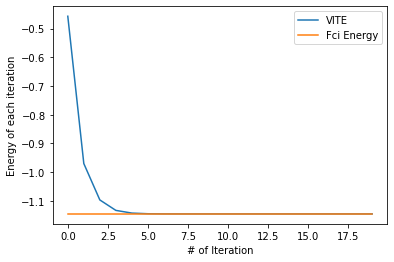

In [46]:
plt.plot(np.real(energy), label = "VITE")
plt.plot([min(x).real] * len(energy), label = "Fci Energy")
plt.xlabel("# of Iteration")
plt.ylabel("Energy of each iteration")
plt.legend()

Eureka!

#### (5). 进一步运用在更复杂的分子体系上

In [50]:
import os 
#os.environ['KMP_DUPLICATE_LIB_OK']="True"
os.environ['OMP_NUM_THREADS'] = '4'
import numpy as np
from openfermion import MolecularData
from openfermionpyscf import run_pyscf

In [51]:
from openfermion import InteractionOperator
from mindquantum.core.operators import PolynomialTensor, get_fermion_operator
from mindquantum import Simulator, Hamiltonian, X, Circuit, FermionOperator, Transform, UCCAnsatz
from mindquantum.framework import MQAnsatzOnlyLayer

In [52]:
def geometry_lih(blens):
    geom = []
    for blen in blens:
        geom.append([('Li', [0, 0, 0]), ('H', [0, 0, blen])])
        
    return geom

def get_intagral_from_tensor(one_body_tensor, two_body_tensor):
    n_qubits = one_body_tensor.shape[0]

    one_body_integral = np.zeros(shape=(n_qubits // 2, n_qubits // 2))
    two_body_integral = np.zeros(shape=(n_qubits // 2, n_qubits // 2, n_qubits // 2, n_qubits // 2))

    for p in range(n_qubits // 2):
        for q in range(n_qubits // 2):
            one_body_integral[p, q] = one_body_tensor[2 * p, 2 * q]

            for r in range(n_qubits // 2):
                for s in range(n_qubits // 2):
                    two_body_integral[p, q, r, s] = two_body_tensor[2 * p, 2 * q, 2 * r, 2 * s] * 2

    return one_body_integral, two_body_integral


def get_active_space_integral(one_body_integral,
                              two_body_integral,
                              occupied_indices,
                              active_indices):
    # Fix data type for a few edge cases
    occupied_indices = [] if occupied_indices is None else occupied_indices
    if (len(active_indices) < 1):
        raise ValueError('Some active indices required for reduction.')

    # Determine core constant
    constant_adujust = 0.0
    for i in occupied_indices:
        # This part come from one_body interaction, if we remove the spin orbital,
        # just add an energy shift for one_body hamiltonian.
        constant_adujust += 2 * one_body_integral[i, i]

        for j in occupied_indices:
            # This part come from the two_body interaction, where the first item is energy shift
            # the second item is because fermion operator anti-commute.
            constant_adujust += (2 * two_body_integral[i, j, j, i] - two_body_integral[i, j, i, j])

    # Modified one electron integrals
    one_body_integral_new = np.copy(one_body_integral)
    for u in active_indices:
        for v in active_indices:
            for i in occupied_indices:
                # If we remove some spin orbital, some Hpqrs would become Hpq, another would be energy shift.
                one_body_integral_new[u, v] += (2 * two_body_integral[i, u, v, i] - two_body_integral[i, u, i, v])

    return (constant_adujust,
            one_body_integral_new[np.ix_(active_indices, active_indices)],
            two_body_integral[np.ix_(active_indices, active_indices,
                                     active_indices, active_indices)])


def get_tensor_from_integral(one_body_integral, two_body_integral):
    n_qubits = 2 * one_body_integral.shape[0]

    one_body_tensor = np.zeros(shape=(n_qubits, n_qubits))
    two_body_tensor = np.zeros(shape=(n_qubits, n_qubits, n_qubits, n_qubits))

    for p in range(n_qubits // 2):
        for q in range(n_qubits // 2):
            one_body_tensor[2 * p, 2 * q] = one_body_integral[p, q]
            one_body_tensor[2 * p + 1, 2 * q + 1] = one_body_integral[p, q]

            for r in range(n_qubits // 2):
                for s in range(n_qubits // 2):
                    # Mixed spin
                    two_body_tensor[2 * p, 2 * q + 1, 2 * r + 1, 2 * s] = (two_body_integral[p, q, r, s] / 2.)
                    two_body_tensor[2 * p + 1, 2 * q, 2 * r, 2 * s + 1] = (two_body_integral[p, q, r, s] / 2.)

                    # Same spin
                    two_body_tensor[2 * p, 2 * q, 2 * r, 2 * s] = (two_body_integral[p, q, r, s] / 2.)
                    two_body_tensor[2 * p + 1, 2 * q + 1, 2 * r + 1, 2 * s + 1] = (two_body_integral[p, q, r, s] / 2.)

    return one_body_tensor, two_body_tensor


def remove_spin_orbital(ham_fermion, eigval_of_rdm, occupied_threshold, remove_threshold, check_orbital=False):
    electron_num = ham_fermion.n_qubits // 2
    if occupied_threshold <= remove_threshold:
        raise ValueError("The occupied threshold should lager then remove threshold")
    if len(eigval_of_rdm) != electron_num:
        raise ValueError("The length of eigval is not same as number of electron, please check the eigval")

    occupied_indices = []
    active_indices = []
    space_indices = [i for i in range(electron_num)]

    occupied_space_orbital = list(np.where(eigval_of_rdm >= occupied_threshold)[0])
    if len(occupied_space_orbital) > 0:
        occupied_indices = [i for i in occupied_space_orbital]

    remove_space_orbital = list(np.where(eigval_of_rdm <= remove_threshold)[0])
    if len(remove_space_orbital) >= 0:
        active_indices = set(space_indices) - (set(occupied_indices + remove_space_orbital))
        active_indices = [i for i in active_indices]

    # If the hamiltonian cannot be simplified, just return the original hamiltonian.
    if len(occupied_space_orbital) == 0 and len(remove_space_orbital) == 0:
        return ham_fermion, ([], [i for i in range(electron_num)])

    constant = ham_fermion.constant
    one_body_integral, two_body_integral = get_intagral_from_tensor(ham_fermion.one_body_tensor,
                                                                    ham_fermion.two_body_tensor)
    constant_adjustment, one_body_integral_new, two_body_integral_new = \
        get_active_space_integral(one_body_integral,
                                  two_body_integral,
                                  occupied_indices,
                                  active_indices)
    constant_new = constant + constant_adjustment
    one_body_tensor, two_body_tensor = get_tensor_from_integral(one_body_integral_new, two_body_integral_new)
    ham_fermion_new = InteractionOperator(constant_new, one_body_tensor, two_body_tensor)
    if check_orbital:
        return ham_fermion_new, (occupied_indices, active_indices)
    else:
        return ham_fermion_new

In [53]:
class VQEoptimizer:
    def __init__(self, max_threshold, min_threshold, molecule, seed=42, file=None):

        self.molecule = molecule
        self.max_threshold = max_threshold
        self.min_threshold = min_threshold
        self.backend = 'mqvector'
        self.seed = seed
        self.file = file

        if molecule != None:
            self.remove_orbital(self.max_threshold, self.min_threshold, molecule)
            self.generate_circuit(molecule)

    def remove_orbital(self, max_threshold, min_threshold, molecule=None):
        if molecule == None:
            molecule = self.molecule
        
        self.ham_fermion = molecule.get_molecular_hamiltonian()
        # Rotation spin orbital
        odm_cisd = molecule.fci_one_rdm
        self.occupied_num_MO, eigvec = np.linalg.eig(odm_cisd)
        Umatrix = np.kron(eigvec, np.eye(2))
        self.ham_fermion.rotate_basis(Umatrix)

        # Remove molecular orbital
        self.remove_ham, self.indices = remove_spin_orbital(self.ham_fermion, self.occupied_num_MO, max_threshold, min_threshold, True)

        # Get the fermion hamiltonian after rotation in openfermion
        new_constant = self.remove_ham.constant
        new_one_body_tensor = self.remove_ham.one_body_tensor
        new_two_body_tensor = self.remove_ham.two_body_tensor

        # Reconstruction fermion operator in mindquantum
        poly_operator = PolynomialTensor({() : new_constant,
                                          (1, 0) : new_one_body_tensor,
                                          (1, 1, 0, 0) : new_two_body_tensor})
        fermion_operator = get_fermion_operator(poly_operator)

        # Get the pauli operator after jordan wigner
        self.ham_pauli = Transform(fermion_operator).jordan_wigner()

    def generate_circuit(self, molecule=None):
        if molecule == None:
            molecule = self.molecule
        occupied_mo_new = self.occupied_num_MO[self.indices[1]]
        occ_orb = np.where(occupied_mo_new > 1.0)[0]
        vir_orb = np.delete(np.arange(len(occupied_mo_new)), occ_orb)

        high_occupied_spin_indice = np.array([[2 * i, 2 * i + 1] for i in occ_orb]).reshape([-1])
        high_occupied_spin_indice = [int(i) for i in high_occupied_spin_indice]

        self.circuit = Circuit([X.on(i) for i in high_occupied_spin_indice])
        self.n_qubits = len(occupied_mo_new) * 2

        ansatz_circuit = UCCAnsatz(self.n_qubits,
                                   molecule.n_electrons - len(self.indices[0]) * 2,
                                   [int(i) for i in occ_orb],
                                   [int(i) for i in vir_orb], trotter_step=1).circuit
        self.circuit += ansatz_circuit

    def optimize(self, learning_rate, eps, operator=None, circuit=None):
        if operator == None:
            operator = self.ham_pauli
        if circuit == None:
            circuit = self.circuit

        self.simulator = Simulator(self.backend, circuit.n_qubits)

        molecule_pqc = self.simulator.get_expectation_with_grad(Hamiltonian(operator.real), circuit)
        molecule_pqcnet = MQAnsatzOnlyLayer(molecule_pqc, 'Zeros')
        energy = []
        initial_energy = molecule_pqcnet()
        energy.append(initial_energy.asnumpy())
        optimizer = ms.nn.Adagrad(molecule_pqcnet.trainable_params(), learning_rate=learning_rate)
        train_pqcnet = ms.nn.TrainOneStepCell(molecule_pqcnet, optimizer)
        energy_diff = eps * 1000
        energy_last = initial_energy.asnumpy() + energy_diff
        iter_idx = 0
        while abs(energy_diff) > eps:
            self.energy_i = train_pqcnet().asnumpy()
            energy_diff = energy_last - self.energy_i
            energy_last = self.energy_i
            iter_idx += 1
            energy.append(energy_last)

        self.optimal_params = molecule_pqcnet.weight.asnumpy()
        #print("The iterations is: {}, and the final convergent energy is: {}".format(iter_idx, self.energy_i),file=file)
        
        return energy
    
    
    def imag_time_evolution(self, operator=None, circuit=None):
        if operator == None:
            operator = self.ham_pauli.real
        if circuit == None:
            circuit = self.circuit

        hamiltonian = Hamiltonian(operator)
        param = np.ones(shape=(len(self.circuit.params_name)))

        energy = []
        ith = 1
        sim = get_phi(param, circuit)
        energy.append(sim.get_expectation(hamiltonian))
        delta = 1000
        while abs(delta) > 1e-5:
            if ith <= 200:
                delta = 1.65
            elif ith > 200:
                delta = 0.25

            mat = get_phi_partial_mat(param, circuit)
            aij = np.real(np.dot(np.conjugate(mat).T, mat))
            ci = get_ci_vec(param, hamiltonian, circuit)
            gradient = np.dot(inverse_aij(aij), ci)
            param = param + delta * gradient

            sim = get_phi(param, circuit)
            energy.append(sim.get_expectation(hamiltonian))
            delta = energy[-1] - energy[-2]
            ith += 1

        self.optimal_params = param
        self.energy_i = energy[-1].real
        print(energy)
        return energy

---

In [54]:
geom = geometry_lih([3.0])[0]
molecule = MolecularData(geom, 'sto3g', 1)
molecule = run_pyscf(molecule, run_scf=1, run_ccsd=1, run_fci=1, run_cisd=1)
max_threshold = 1.9995
min_threshold = 8e-4
vqe = VQEoptimizer(max_threshold=max_threshold, min_threshold=min_threshold, molecule=molecule)
operator = vqe.ham_pauli
circuit = vqe.circuit

/home/ma-user/anaconda3/envs/MindQuantum/lib/python3.7/site-packages/mindquantum/algorithm/nisq/chem/uccsd0.py:348: UserWarning: [Note] Override n_qubits and n_electrons with manually set occ_orb and vir_orb. Handle with caution!
  "[Note] Override n_qubits and n_electrons with manually set occ_orb and vir_orb. Handle with caution!"


In [55]:
hamiltonian = Hamiltonian(operator.real)
param = np.ones(shape=(len(circuit.params_name)))
aij_ops = partial_psi_partial_psi(circuit)
ci_ops = get_ci_matrix(circuit)

energy = []
ith = 1
sim = get_phi(param, circuit)
energy.append(sim.get_expectation(hamiltonian).real)
delta = 0.50
while ith < 100:
    aij = np.real(aij_ops(param))
    ci = -np.real(ci_ops(param, hamiltonian))
    gradient = np.dot(inverse_aij(aij), ci)
    param = param + delta * gradient

    sim = get_phi(param, circuit)
    energy.append(sim.get_expectation(hamiltonian).real)
    ith += 1
    energy_diff = energy[-1] - energy[-2]
    #print(ith, energy[-1])
    
    if ith >= 25 and abs(energy_diff) < 1e-4:
        break
    
    if ith == 1:
        pass
    else:
        if energy_diff < 0:
            delta *= 1.05
        else:
            delta /= 2

optimal_params = param
energy_i = energy[-1].real

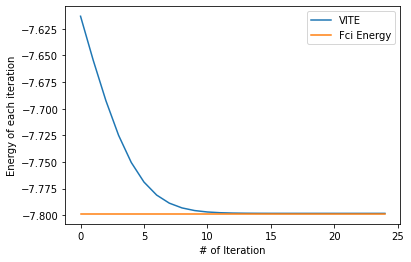

In [38]:
plt.plot(np.real(energy), label = "VITE")
plt.plot([molecule.fci_energy] * len(energy), label = "Fci Energy")
plt.xlabel("# of Iteration")
plt.ylabel("Energy of each iteration")
plt.legend()

Therefore, according to the results, even for more complex molecular systems, the VITE based on the Mindquatum library can still effectively calculate the groud-state energy! And so far, we have basically completed the basic goals required by the project. 

But we didn't stop there, we continued to think about whether quantum noise will have a huge impact on the convergence of the algorithm, because the inverse of the $A_{ij}$ matrix is required.

#### (6). 探究噪声对于算法的影响

Here we first consider the impact of circuit noise on the algorithm implement. There is a kind of noise that affects the quantum circuit. After a certain quantum operation, the circuit is likely to be affected by an additional pauli gate, which is called a pauli channel. And if the X, Y, Z gates split equally, it is called a depolarization channel. This channel is often used to describe the noise generated by gate operation in real quantum hardware. And it's described by,
$$
\epsilon_{DF}(\rho) = (1-p)\rho + \frac{p}{3}(X\rho X + Y\rho Y + Z\rho Z)
$$
But the problem we face is how to introduce the noise on the quantum circuit. Due to the characteristics of the Mindqauntum library, if we use the noise port provided by itself to simulate the noise, then the previous function cannot be used to obtain the gradient of quantum state. So this requires us to construct the noise-containing circuit and design an algorithm to simulate the effect. What we adopt is a method based on Monte Carlo idea to introduce random numbers to randomize a large number of samples, and then take the mean value, so as to approximate the real moise circuit. 

In [13]:
import copy
def noise_circ(circ, p):
    circ_copy = circ.copy()
    circ1 = copy.deepcopy(circ)
    j = 0
    for i, gate in enumerate(circ_copy):
        if isinstance(gate, BarrierGate):
            j += 1
        else:
            if np.random.random() <= p:
                random_num = np.random.random()
                #print(random_num)
                if random_num < 1/3:
                    circ1.insert(i+j+1, X.on(gate.obj_qubits))
                elif 1/3 <= random_num <= 2/3:
                    circ1.insert(i+j+1, Y.on(gate.obj_qubits))
                elif 2/3 <= random_num < 1:
                    circ1.insert(i+j+1, Z.on(gate.obj_qubits))
                else:
                    raise ValueError('Check the random number')
                j += 1
    return circ1        

In [14]:
def sampling_aij(circ, param, shots, p):
    aij = 0
    ci = 0
    for i in range(shots):
        sampling_circ = noise_circ(circ, p)
        
        aij_ops = partial_psi_partial_psi(sampling_circ)
        aij += np.real(aij_ops(param))
        
        ci_ops = get_ci_matrix(sampling_circ)
        ci -= np.real(ci_ops(param ,hamiltonian))
        #print(i)
    aij = aij / shots
    ci = ci / shots
    
    return aij, ci

In [31]:
def noise_VITE(circ, shots, p):
    param = np.ones(shape=(len(circuit.params_name)))

    energy_noise = []
    ith = 1
    sim = get_phi(param, circuit)
    energy_noise.append(sim.get_expectation(hamiltonian).real)
    delta = 0.25
    while ith < 50:
        aij, ci = sampling_aij(circuit, param, shots, p)
        gradient = np.dot(inverse_aij(aij), ci)
        param = param + delta * gradient

        sim = get_phi(param, circuit)
        energy_noise.append(sim.get_expectation(hamiltonian).real)
        ith += 1
        energy_diff = energy_noise[-1] - energy_noise[-2]
        #print(ith, energy_noise[-1])

        if ith >= 20 and abs(energy_diff) <= 1e-5:
            break

        if ith == 1:
            pass
        else:
            if energy_diff < 0:
                delta *= 1.05
            else:
                delta /= 2

        optimal_params = param
        energy_i = energy[-1].real
        
    return energy_noise, param

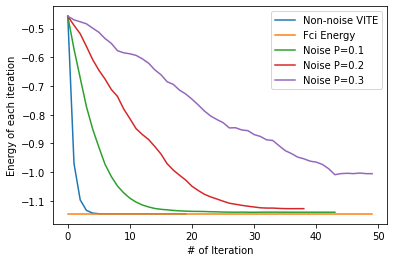

In [30]:
noise_1 = np.load("./data/H2_molecular_noise_0.1.npy")
noise_2 = np.load("./data/H2_molecular_noise_0.2.npy")
noise_3 = np.load("./data/H2_molecular_noise_0.3.npy")

plt.plot(np.array(energy), label = "Non-noise VITE")
plt.plot([min(x).real] * 50, label = "Fci Energy")
plt.plot(np.array(noise_1), label = "Noise P=0.1")
plt.plot(np.array(noise_2), label = "Noise P=0.2")
plt.plot(np.array(noise_3), label = "Noise P=0.3")
plt.xlabel("# of Iteration")
plt.ylabel("Energy of each iteration")
plt.legend()

As shown in the result figure, when the quantum circuit noise is introduced, the stability of the algorithm will be affected and its convergence speed will be greatly slowed down. Even when the noise gradually increases, we find that the algorithm will fail and cannot converge to the ground state energy. But this is only the effect of hydrogen molecules on a shallow circuit. So we thought about whether the effect of noise would be different for more complex molecules on deeper circuit. So next, we still select LiH molecule to explore the impact of noise on the VITE algorithm。

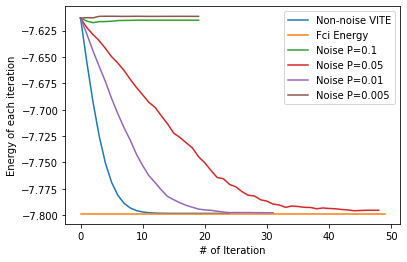

In [39]:
noise_1 = np.load("./data/LiH_molecular_noise_0.1.npy")
noise_2 = np.load("./data/LiH_molecular_noise_0.01.npy")
noise_3 = np.load("./data/LiH_molecular_noise_0.05.npy")
noise_4 = np.load("./data/LiH_molecular_noise_0.005.npy")

plt.plot(np.array(energy), label = "Non-noise VITE")
plt.plot([molecule.fci_energy] * 50, label = "Fci Energy")
plt.plot(np.array(noise_1), label = "Noise P=0.1")
plt.plot(np.array(noise_2), label = "Noise P=0.05")
plt.plot(np.array(noise_4), label = "Noise P=0.01")
plt.plot(np.array(noise_3), label = "Noise P=0.005")

plt.xlabel("# of Iteration")
plt.ylabel("Energy of each iteration")
plt.legend()

The results in the figure once again verify our conjecture that for deeper lines, the implementation of the VITE algorithm will be more vulnerable to noise.

## 4.主要参考文献
[1] McArdle, Sam, et al. "Quantum computational chemistry." Reviews of Modern Physics 92.1 (2020): 015003.

[2] McArdle, Sam, et al. "Variational ansatz-based quantum simulation of imaginary time evolution." npj Quantum Information 5.1 (2019): 1-6.

[3] Li, Ying, and Simon C. Benjamin. "Efficient variational quantum simulator incorporating active error minimization." Physical Review X 7.2 (2017): 021050.

[4] Motta, Mario, et al. "Determining eigenstates and thermal states on a quantum computer using quantum imaginary time evolution." Nature Physics 16.2 (2020): 205-210.

[5] Seeley, Jacob T., Martin J. Richard, and Peter J. Love. "The Bravyi-Kitaev transformation for quantum computation of electronic structure." The Journal of chemical physics 137.22 (2012): 224109.

[6] Li, Yifan, et al. "Variational quantum simulation for quantum chemistry." Advanced Theory and Simulations 2.4 (2019): 1800182.